In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, TargetEncoder
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.cluster import MiniBatchKMeans


In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# create new york data before 
link = './accident dataset/US_Accidents_March23.csv'
data = pd.read_csv(link)
data = data[
    (data.State == 'NY') |
    (data.State == 'NJ')
]
path = './accident dataset/New York Accidents_2.csv'
data.to_csv(path_or_buf=path, encoding='utf-8', index=False)

Delete above data from memory to free up your ram space

In [3]:
link = './accident dataset/New York Accidents_2.csv'
data = pd.read_csv(link)
data.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-194256,Source2,2,2016-11-30 16:37:24,2016-11-30 17:22:05,40.775616,-74.237305,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Day,Day,Day
1,A-194257,Source2,3,2016-11-30 16:25:41,2016-11-30 17:10:30,41.139324,-74.169876,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day
2,A-194258,Source2,3,2016-11-30 15:40:06,2016-11-30 17:09:40,41.118748,-74.159744,NaN,NaN,2.53,...,False,False,False,False,False,False,Day,Day,Day,Day
3,A-194259,Source2,3,2016-11-30 15:26:18,2016-11-30 16:56:02,41.014034,-73.717239,NaN,NaN,1.17,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-194260,Source2,3,2016-11-30 16:14:11,2016-11-30 16:59:00,41.390369,-73.597969,NaN,NaN,0.01,...,False,False,False,False,False,False,Day,Day,Day,Day


In [4]:
data.shape

(488679, 46)

# Data Preprocessing 

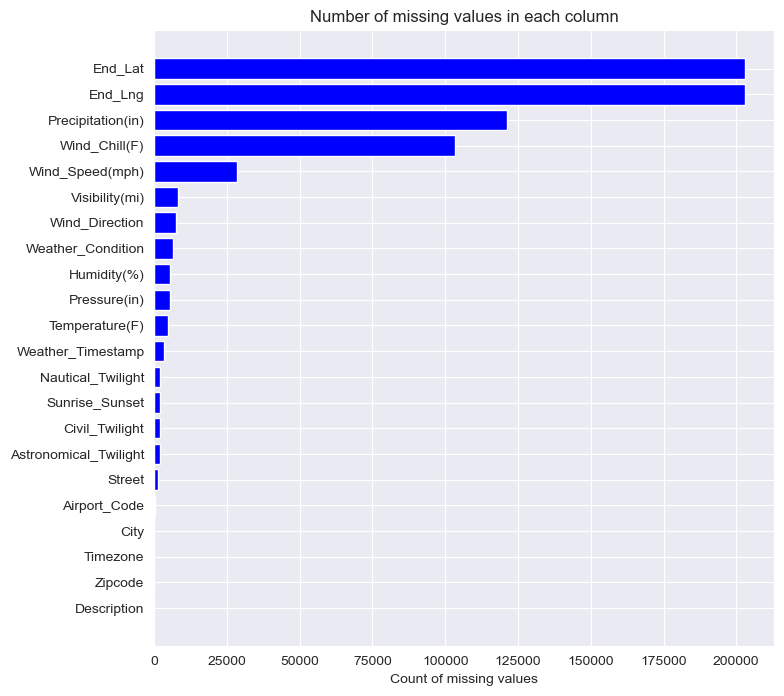

In [5]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(8,8))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [6]:
# Create a DataFrame with missing values and their percentages
missing = pd.DataFrame(data.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Count']
missing['Missing_Percent(%)'] = (missing['Missing_Count'] / data.shape[0]) * 100

# Add data types to the DataFrame
missing['Data_Type'] = data.dtypes.values

# Filter and display rows with missing values
missing_filtered = missing.loc[missing['Missing_Percent(%)'] > 0, :]

# Display the table with missing values and data types
print("Features with Missing Values:")
print(missing_filtered)

Features with Missing Values:
                  Feature  Missing_Count  Missing_Percent(%) Data_Type
7                 End_Lat         202901           41.520303   float64
8                 End_Lng         202901           41.520303   float64
10            Description              1            0.000205    object
11                 Street           1163            0.237989    object
12                   City             28            0.005730    object
15                Zipcode              1            0.000205    object
17               Timezone              1            0.000205    object
18           Airport_Code            359            0.073463    object
19      Weather_Timestamp           3442            0.704348    object
20         Temperature(F)           4860            0.994518   float64
21          Wind_Chill(F)         103224           21.123069   float64
22            Humidity(%)           5482            1.121800   float64
23           Pressure(in)           5251       

# Removal of features 
* Removing certain features from the dataset is a prudent decision based on their limited predictive value or redundancy. Features like 'ID' and 'Source' lack meaningful information

In [7]:
data = data.drop(['ID','Source'], axis=1)

In [8]:
data.Start_Time.str.len().value_counts()

Start_Time
19    434439
29     50152
26      4088
Name: count, dtype: int64

In [9]:
# whats 26 and 29? 
data.Start_Time[
    (data.Start_Time.str.len() == 26) |
    (data.Start_Time.str.len() == 29)
    ]

221469    2023-02-26 09:31:45.000000000
221470    2023-03-26 01:07:20.000000000
221471    2023-02-27 11:05:08.000000000
221472    2023-02-27 18:34:00.000000000
221473    2023-03-29 08:22:00.000000000
                      ...              
436718    2020-11-28 06:59:09.000000000
436719    2020-12-20 00:57:00.000000000
436720    2020-10-24 15:35:00.000000000
436721    2020-11-12 15:15:30.000000000
436722    2020-12-17 10:10:16.000000000
Name: Start_Time, Length: 54240, dtype: object

In [10]:
data.End_Time[
    (data.End_Time.str.len() == 26) |
    (data.End_Time.str.len() == 29)
    ]

221469    2023-02-26 11:58:19.000000000
221470    2023-03-26 03:12:26.000000000
221471    2023-02-27 13:11:58.000000000
221472    2023-02-27 20:39:25.000000000
221473    2023-03-29 10:30:01.000000000
                      ...              
436718    2020-11-28 08:41:38.000000000
436719    2020-12-20 05:03:35.000000000
436720    2020-10-24 20:42:45.000000000
436721    2020-11-13 00:44:08.000000000
436722    2020-12-17 12:54:49.000000000
Name: End_Time, Length: 54240, dtype: object

In [11]:
data.Start_Time = pd.to_datetime(data.Start_Time.str[:19])
data.End_Time = pd.to_datetime(data.End_Time.str[:19])

Getting metrics for Time taken (total time of the accident) 

In [12]:
print((data.End_Time - data.Start_Time).dt.seconds.mean())

7014.709146494938


In [13]:
data[(data.End_Time - data.Start_Time).dt.seconds == 0].Description

443669    Closed at US-11/Brewerton Rd - Road closed due...
443670    Closed at US-11/Brewerton Rd - Road closed due...
443675    Closed at US-11/Brewerton Rd - Road closed due...
443676    Closed at US-11/Brewerton Rd - Road closed due...
443677    Closed at US-11/Brewerton Rd - Road closed due...
443678    Closed at US-11/Brewerton Rd - Road closed due...
Name: Description, dtype: object

In [14]:
data['TimeTaken'] = (data.End_Time - data.Start_Time).dt.seconds

In [15]:
columns_to_drop = ['End_Time', 'End_Lat', 'End_Lng', 'Description', 'County','City', 'State', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp']
data = data.drop(columns=columns_to_drop, axis=1)
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Wind_Chill(F),Humidity(%),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,40.775616,-74.237305,0.01,Main St,07050-1520,55.0,NaN,93.0,...,False,False,False,True,False,Night,Day,Day,Day,2681
1,3,2016-11-30 16:25:41,41.139324,-74.169876,0.01,Route 17,10974,53.1,NaN,93.0,...,False,False,False,False,False,Day,Day,Day,Day,2689
2,3,2016-11-30 15:40:06,41.118748,-74.159744,2.53,I-287 S,10901,53.1,NaN,93.0,...,False,False,False,False,False,Day,Day,Day,Day,5374
3,3,2016-11-30 15:26:18,41.014034,-73.717239,1.17,Hutchinson River Pkwy S,10605,52.0,NaN,93.0,...,False,False,False,False,False,Day,Day,Day,Day,5384
4,3,2016-11-30 16:14:11,41.390369,-73.597969,0.01,I-84 E,10509,52.0,NaN,89.0,...,False,False,False,False,False,Day,Day,Day,Day,2689


In [16]:
correlation = data['Temperature(F)'].corr(data['Wind_Chill(F)'])
print("Correlation between Temperature and Wind chill:", correlation)

Correlation between Temperature and Wind chill: 0.9926101475996887


In [17]:
# Specify the columns you want to check for null values
columns_to_check = ['Temperature(F)', 'Wind_Chill(F)']

# Check for null values in the specified columns
null_counts_in_columns = data[columns_to_check].isnull().sum()

# Display the count of null values in the specified columns
print("Number of Null Values in Specified Columns:")
print(null_counts_in_columns)

Number of Null Values in Specified Columns:
Temperature(F)      4860
Wind_Chill(F)     103224
dtype: int64


Both columns have nearly 1 corelation value, so we can afford to drop one of them. Since wind chill has more null values, we are removing wind chill 

In [18]:
data = data.drop(['Wind_Chill(F)'], axis=1)
temperature_median = data['Temperature(F)'].median()

# Fill null values in the 'Temperature(F)' column with the median
data['Temperature(F)'].fillna(temperature_median, inplace=True)

In [19]:
# Check for null values in the specified columns
null_counts_in_columns = data['Temperature(F)'].isnull().sum()

# Display the count of null values in the specified columns
print("Number of Null Values in Specified Columns:")
print(null_counts_in_columns)

Number of Null Values in Specified Columns:
0


In [20]:
print("Wind Direction: ", data['Wind_Direction'].unique())

Wind Direction:  ['ENE' 'East' 'South' 'SSE' 'NE' 'NNE' 'Variable' 'North' 'West' 'WSW'
 'Calm' 'NW' 'WNW' 'SW' 'ESE' 'NNW' 'SE' 'SSW' nan 'N' 'VAR' 'CALM' 'E'
 'S' 'W']


In [21]:
data.loc[(data['Wind_Direction']=='North')|(data['Wind_Direction']=='NNW')|(data['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
data.loc[(data['Wind_Direction']=='South')|(data['Wind_Direction']=='SSW')|(data['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
data.loc[(data['Wind_Direction']=='East')|(data['Wind_Direction']=='ESE')|(data['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
data.loc[(data['Wind_Direction']=='West')|(data['Wind_Direction']=='WSW')|(data['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
data.loc[data['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
data.loc[data['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", data['Wind_Direction'].unique())

Wind Direction after simplification:  ['E' 'S' 'NE' 'N' 'VAR' 'W' 'CALM' 'NW' 'SW' 'SE' nan]


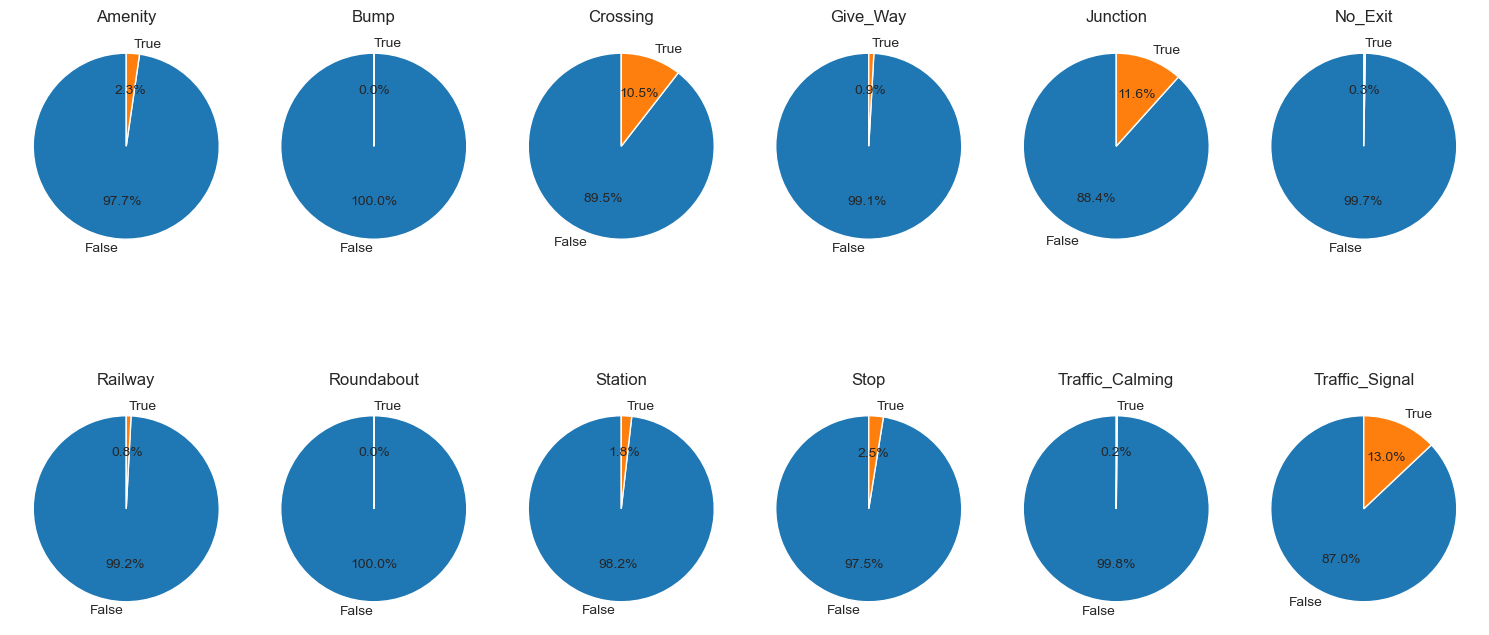

In [22]:
import matplotlib.pyplot as plt

# Specify the columns to create pie charts for
poi_columns = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
               'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

# Set up subplots for each column in a 2x6 grid
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()

# Loop through each column and create a pie chart
for i, column in enumerate(poi_columns):
    poi_counts = data[column].value_counts()
    # Check if there are values to plot
    if not poi_counts.empty:
        axes[i].pie(poi_counts, labels=poi_counts.index, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(column)

# Adjust layout
plt.tight_layout()

# Show the pie charts
plt.show()


In [23]:
data[['Amenity','Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway','Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']]

,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Day,Day,Day
1,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
3,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
4,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488674,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
488675,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
488676,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
488677,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day


Converting boolean values to 0 and 1 

In [24]:
data[['Amenity','Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway','Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Turning_Loop']] = data[['Amenity','Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway','Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Turning_Loop']].astype(int)
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,40.775616,-74.237305,0.01,Main St,07050-1520,55.0,93.0,29.79,...,0,0,0,1,0,Night,Day,Day,Day,2681
1,3,2016-11-30 16:25:41,41.139324,-74.169876,0.01,Route 17,10974,53.1,93.0,29.81,...,0,0,0,0,0,Day,Day,Day,Day,2689
2,3,2016-11-30 15:40:06,41.118748,-74.159744,2.53,I-287 S,10901,53.1,93.0,29.83,...,0,0,0,0,0,Day,Day,Day,Day,5374
3,3,2016-11-30 15:26:18,41.014034,-73.717239,1.17,Hutchinson River Pkwy S,10605,52.0,93.0,29.81,...,0,0,0,0,0,Day,Day,Day,Day,5384
4,3,2016-11-30 16:14:11,41.390369,-73.597969,0.01,I-84 E,10509,52.0,89.0,29.86,...,0,0,0,0,0,Day,Day,Day,Day,2689


In [25]:
# Create a DataFrame with missing values and their percentages
missing = pd.DataFrame(data.isnull().sum()).reset_index()
missing.columns = ['Feature', 'Missing_Count']
missing['Missing_Percent(%)'] = (missing['Missing_Count'] / data.shape[0]) * 100

# Add data types to the DataFrame
missing['Data_Type'] = data.dtypes.values

# Filter and display rows with missing values
missing_filtered = missing.loc[missing['Missing_Percent(%)'] > 0, :]

# Display the table with missing values and data types
print("Features with Missing Values:")
print(missing_filtered)

Features with Missing Values:
                  Feature  Missing_Count  Missing_Percent(%) Data_Type
5                  Street           1163            0.237989    object
6                 Zipcode              1            0.000205    object
8             Humidity(%)           5482            1.121800   float64
9            Pressure(in)           5251            1.074529   float64
10         Visibility(mi)           8297            1.697843   float64
11         Wind_Direction           7463            1.527178    object
12        Wind_Speed(mph)          28571            5.846578   float64
13      Precipitation(in)         121193           24.800124   float64
14      Weather_Condition           6329            1.295124    object
28         Sunrise_Sunset           1972            0.403537    object
29         Civil_Twilight           1972            0.403537    object
30      Nautical_Twilight           1972            0.403537    object
31  Astronomical_Twilight           1972       

* In the process of handling missing data in a project, it's crucial to choose the appropriate imputation strategy based on the characteristics of the variables. Here's a breakdown of our approach:


# Median for Numerical Data:

We opt for the median when dealing with numerical features. This is particularly useful in scenarios where the data distribution is skewed or outliers are present. The median is less influenced by extreme values, making it a robust measure of central tendency. We apply median imputation to essential numerical variables such as Temperature, Wind_Chill, Humidity, Pressure, Visibility, Wind_Speed, and Precipitation.

# Mode for Categorical Data:

For categorical features, we choose mode imputation, as it represents the most frequently occurring category in the dataset. This approach is suitable for handling missing values in categorical variables like Wind_Direction, Weather_Condition, Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, and Astronomical_Twilight. It's important to ensure that the mode is a meaningful representation of the data and isn't heavily influenced by rare or infrequent categories. By employing these imputation strategies, we aim to maintain the reliability of our data while addressing missing values in a statistically sound manner within the context of our project.

In [27]:
float_columns = ['Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
data[float_columns] = data[float_columns].fillna(data[float_columns].median())

# Fill missing values for object dtype columns with mode
object_columns = ['Street', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight','Nautical_Twilight', 'Astronomical_Twilight']
data[object_columns] = data[object_columns].fillna(data[object_columns].mode().iloc[0])

# Verify the changes
data.isnull().sum()

Severity                 0
Start_Time               0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Street                   0
Zipcode                  1
Temperature(F)           0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
TimeTaken                0
dtype: int64

In [28]:
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,40.775616,-74.237305,0.01,Main St,07050-1520,55.0,93.0,29.79,...,0,0,0,1,0,Night,Day,Day,Day,2681
1,3,2016-11-30 16:25:41,41.139324,-74.169876,0.01,Route 17,10974,53.1,93.0,29.81,...,0,0,0,0,0,Day,Day,Day,Day,2689
2,3,2016-11-30 15:40:06,41.118748,-74.159744,2.53,I-287 S,10901,53.1,93.0,29.83,...,0,0,0,0,0,Day,Day,Day,Day,5374
3,3,2016-11-30 15:26:18,41.014034,-73.717239,1.17,Hutchinson River Pkwy S,10605,52.0,93.0,29.81,...,0,0,0,0,0,Day,Day,Day,Day,5384
4,3,2016-11-30 16:14:11,41.390369,-73.597969,0.01,I-84 E,10509,52.0,89.0,29.86,...,0,0,0,0,0,Day,Day,Day,Day,2689


In [29]:
data[data['Temperature(F)'] < -20]['Temperature(F)']

4438     -77.8
4456     -77.8
4780     -77.8
4781     -77.8
160492   -77.8
160493   -77.8
160500   -77.8
177719   -77.8
184112   -77.8
184117   -77.8
478891   -77.8
Name: Temperature(F), dtype: float64

In [35]:
data['Temperature(F)'] = data['Temperature(F)'].where(data['Temperature(F)'] != -77.8,77.8)
data[data['Temperature(F)'] < -20]['Temperature(F)']

Series([], Name: Temperature(F), dtype: float64)

In [30]:
data = data.drop(columns='Precipitation(in)', axis=1)
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,40.775616,-74.237305,0.01,Main St,07050-1520,55.0,93.0,29.79,...,0,0,0,1,0,Night,Day,Day,Day,2681
1,3,2016-11-30 16:25:41,41.139324,-74.169876,0.01,Route 17,10974,53.1,93.0,29.81,...,0,0,0,0,0,Day,Day,Day,Day,2689
2,3,2016-11-30 15:40:06,41.118748,-74.159744,2.53,I-287 S,10901,53.1,93.0,29.83,...,0,0,0,0,0,Day,Day,Day,Day,5374
3,3,2016-11-30 15:26:18,41.014034,-73.717239,1.17,Hutchinson River Pkwy S,10605,52.0,93.0,29.81,...,0,0,0,0,0,Day,Day,Day,Day,5384
4,3,2016-11-30 16:14:11,41.390369,-73.597969,0.01,I-84 E,10509,52.0,89.0,29.86,...,0,0,0,0,0,Day,Day,Day,Day,2689


Preprocessing for Sunlight, sunset...

In [31]:
data[['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']].value_counts()

Sunrise_Sunset  Civil_Twilight  Nautical_Twilight  Astronomical_Twilight
Day             Day             Day                Day                      341900
Night           Night           Night              Night                     80803
                                Day                Day                       23666
                Day             Day                Day                       22625
                Night           Night              Day                       19685
Name: count, dtype: int64

In [32]:
data[['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']].isnull().sum()

Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
dtype: int64

Label encoding all these columns 

In [33]:
le = LabelEncoder()
data[['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']] = data[['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']].apply(le.fit_transform)
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,40.775616,-74.237305,0.01,Main St,07050-1520,55.0,93.0,29.79,...,0,0,0,1,0,1,0,0,0,2681
1,3,2016-11-30 16:25:41,41.139324,-74.169876,0.01,Route 17,10974,53.1,93.0,29.81,...,0,0,0,0,0,0,0,0,0,2689
2,3,2016-11-30 15:40:06,41.118748,-74.159744,2.53,I-287 S,10901,53.1,93.0,29.83,...,0,0,0,0,0,0,0,0,0,5374
3,3,2016-11-30 15:26:18,41.014034,-73.717239,1.17,Hutchinson River Pkwy S,10605,52.0,93.0,29.81,...,0,0,0,0,0,0,0,0,0,5384
4,3,2016-11-30 16:14:11,41.390369,-73.597969,0.01,I-84 E,10509,52.0,89.0,29.86,...,0,0,0,0,0,0,0,0,0,2689


# EDA 

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


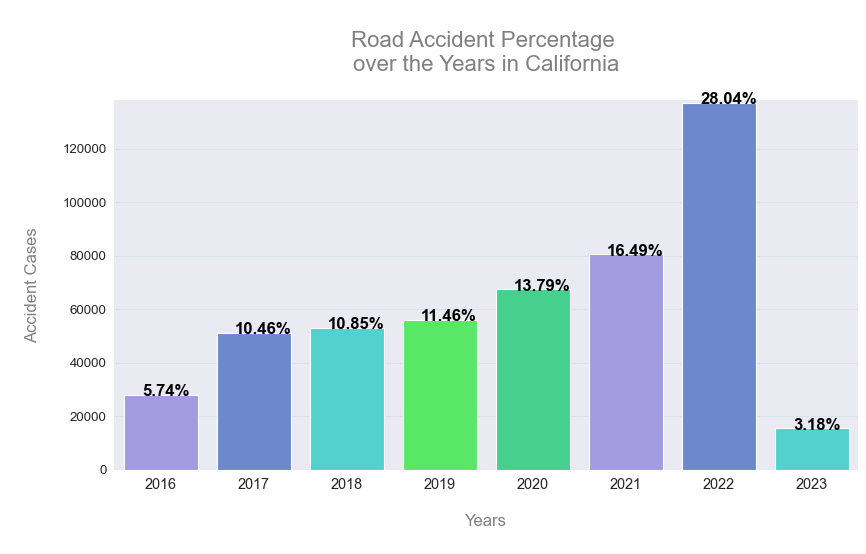

In [36]:

#data['Start_Time'] = pd.to_datetime(data['Start_Time'])


newyork_year = pd.DataFrame(data['Start_Time'].dt.year.value_counts()).reset_index().rename(columns={'count':'Cases', 'Start_Time':'Year'}).sort_values(by='Cases', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6), dpi=80)

# If not, replace them with the correct column names.
ax = sns.barplot(y=newyork_year['Cases'], x=newyork_year['Year'], palette=['#9a90e8', '#5d82de', '#3ee6e0', '#40ff53', '#2ee88e'])

total = newyork_year['Cases'].sum()
for i in ax.patches:
    ax.text(i.get_x() + 0.2, i.get_height() - 500, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=15, weight='bold',
            color='black')

plt.ylim(0, newyork_year['Cases'].max() + 1000)
plt.title('\nRoad Accident Percentage \nover the Years in New york\n', size=20, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=15, color='grey')
plt.xlabel('\nYears\n', fontsize=15, color='grey')
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)

# Remove spines
for i in ['bottom', 'top', 'left', 'right']:
    ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)

# Hide the remaining spines
for k in ['top', 'right', "bottom", 'left']:
    side = ax.spines[k]
    side.set_visible(False)

ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, axis='y', alpha=0.3)

plt.show()

In [37]:
# Filter out rows with the year 2023
data = data[data['Start_Time'].dt.year < 2023]

# Verify the changes
data['Start_Time'].dt.year.unique()

array([2016, 2017, 2022, 2021, 2020, 2019, 2018], dtype=int32)

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


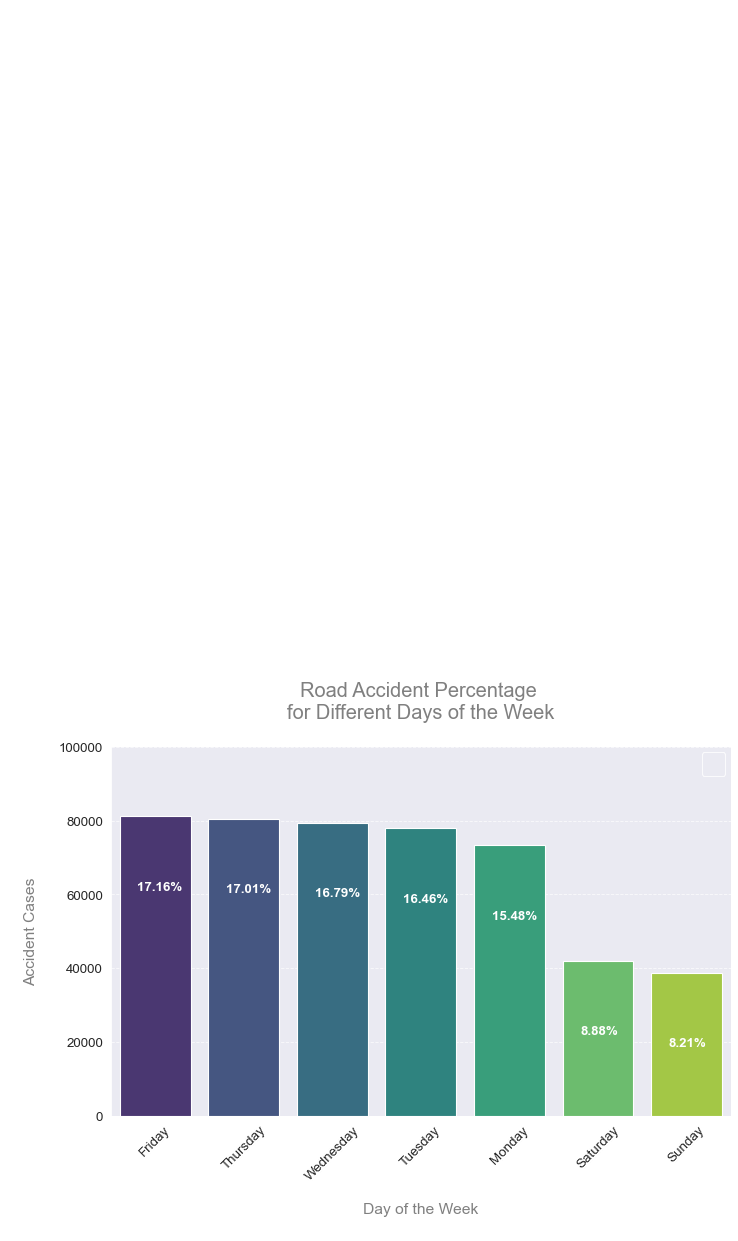

In [38]:
# Assuming df_processed is your DataFrame
X = data.copy()

# Convert "Start_Time" to datetime
X["Start_Time"] = pd.to_datetime(X["Start_Time"])

# Create a DataFrame for day-wise analysis
day_df = pd.DataFrame(X.Start_Time.dt.day_name().value_counts()).reset_index().rename(columns={'count': 'Cases', 'Start_Time': 'Day'})

# Plotting
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

# Use seaborn to create a bar plot with a custom color palette
ax = sns.barplot(y=day_df['Cases'], x=day_df['Day'], palette='viridis')

total = X.shape[0]
for i in ax.patches:
    ax.text(i.get_x() + 0.2, i.get_height() - 20000,
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=12, weight='bold',
            color='white')

plt.ylim(0, 100000)
plt.title('\nRoad Accident Percentage \nfor Different Days of the Week\n', size=18, color='grey')
plt.ylabel('\nAccident Cases\n', fontsize=14, color='grey')
plt.xlabel('\nDay of the Week\n', fontsize=14, color='grey')
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove spines
for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

ax.set_axisbelow(True)
ax.spines['bottom'].set_bounds(0.005, 6)
ax.spines['left'].set_bounds(0, 300000)

# Display legend
ax.legend(handles=[], prop={'size': 10.5}, loc='best', borderpad=1, edgecolor='white', labelcolor=['#4E5180', '#C5CBE3'])

plt.show();

/var/folders/2b/36p5ztyn4yj61wp8q88_2fxh0000gn/T/ipykernel_73514/271944503.py:15: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(hour_df[hour_df['Cases'] == x]['Hour']) <= 11:
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depreca

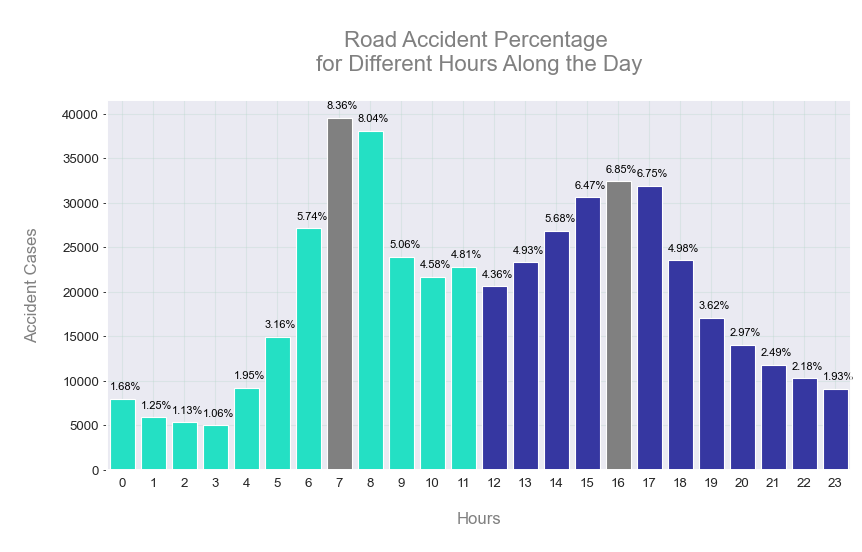

In [39]:
# Assuming df_processed is your DataFrame
X = data.copy()

# Convert "Start_Time" to datetime
X["Start_Time"] = pd.to_datetime(X["Start_Time"])

# Extract hour and create a DataFrame
hour_df = pd.DataFrame(X.Start_Time.dt.hour.value_counts()).reset_index().rename(columns={'count': 'Cases', 'Start_Time': 'Hour'}).sort_values('Hour')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), dpi=80)

clrs = []
for x in hour_df['Cases']:
    if int(hour_df[hour_df['Cases'] == x]['Hour']) <= 11:
        if (x == max(list(hour_df['Cases'])[:12])):
            clrs.append('grey')
        else:
            clrs.append('#05ffda')
    else:
        if (x == max(list(hour_df['Cases'])[12:])):
            clrs.append('grey')
        else:
            clrs.append('#2426b3')

ax = sns.barplot(y=hour_df['Cases'], x=hour_df['Hour'], palette=clrs)
ax1 = ax.twinx()

# sns.lineplot(data=hour_df, marker='o', x='Hour', y='Cases', color='white', alpha=1)

total = X.shape[0]
for i in ax.patches:
    ax.text(i.get_x(), i.get_height() + 1000,
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=10,
            color='black')

plt.ylim(1000, 150000)
plt.title('\nRoad Accident Percentage \nfor Different Hours Along the Day\n', size=20, color='grey')

ax1.axes.yaxis.set_visible(False)
ax.set_xlabel('\nHours\n', fontsize=15, color='grey')
ax.set_ylabel('\nAccident Cases\n', fontsize=15, color='grey')

for i in ['bottom', 'top', 'left', 'right']:
    #     ax.spines[i].set_color('white')
    ax.spines[i].set_linewidth(1.5)
    #     ax1.spines[i].set_color('white')
    ax1.spines[i].set_linewidth(1.5)

ax.set_axisbelow(True)
ax.grid(color='#b2d6c7', linewidth=1, alpha=.3)
ax.tick_params(axis='both', which='major', labelsize=12)

MA = mpatches.Patch(color='grey', label='Hour with Maximum\n no. of Road Accidents')
MO = mpatches.Patch(color='#05ffda', label='Morning Hours')
NI = mpatches.Patch(color='#2426b3', label='Night Hours')

# ax.legend(handles=[MA, MO, NI], prop={'size': 10.5}, loc='upper left', borderpad=1, edgecolor='white')

plt.show()

# CHECK

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

AttributeError: 'numpy.int32' object has no attribute 'startswith'

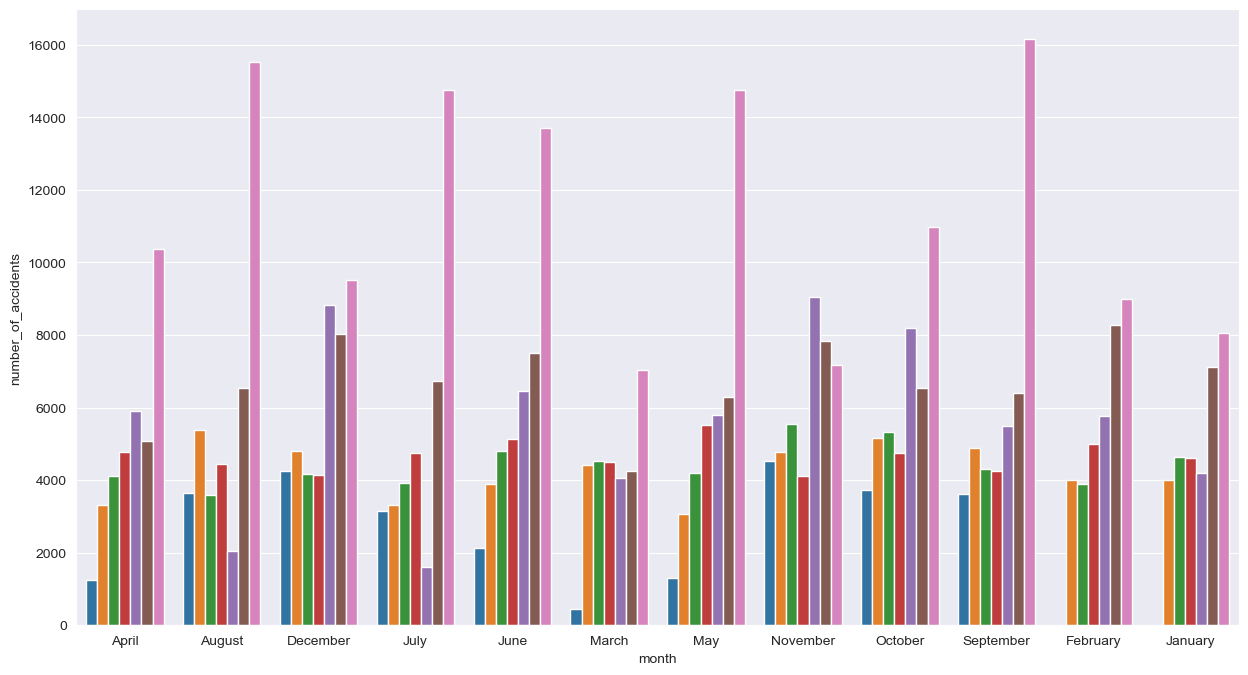

In [40]:
X = data.copy()

X['Start_Time'] = pd.to_datetime(X['Start_Time'])

# Extract month and year from 'Start_Time'
X['month'] = X['Start_Time'].dt.month
X['year'] = X['Start_Time'].dt.year

# Map numerical month to its corresponding name
X['month'] = X['month'].map({
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
})

# Create a DataFrame for monthly accidents
monthly_accidents = X.groupby(['year', 'month']).size().reset_index(name='number_of_accidents')

# Plot the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x="month", y="number_of_accidents", hue="year", data=monthly_accidents)
plt.title('Monthly Accidents in New york Over the Years')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.show()

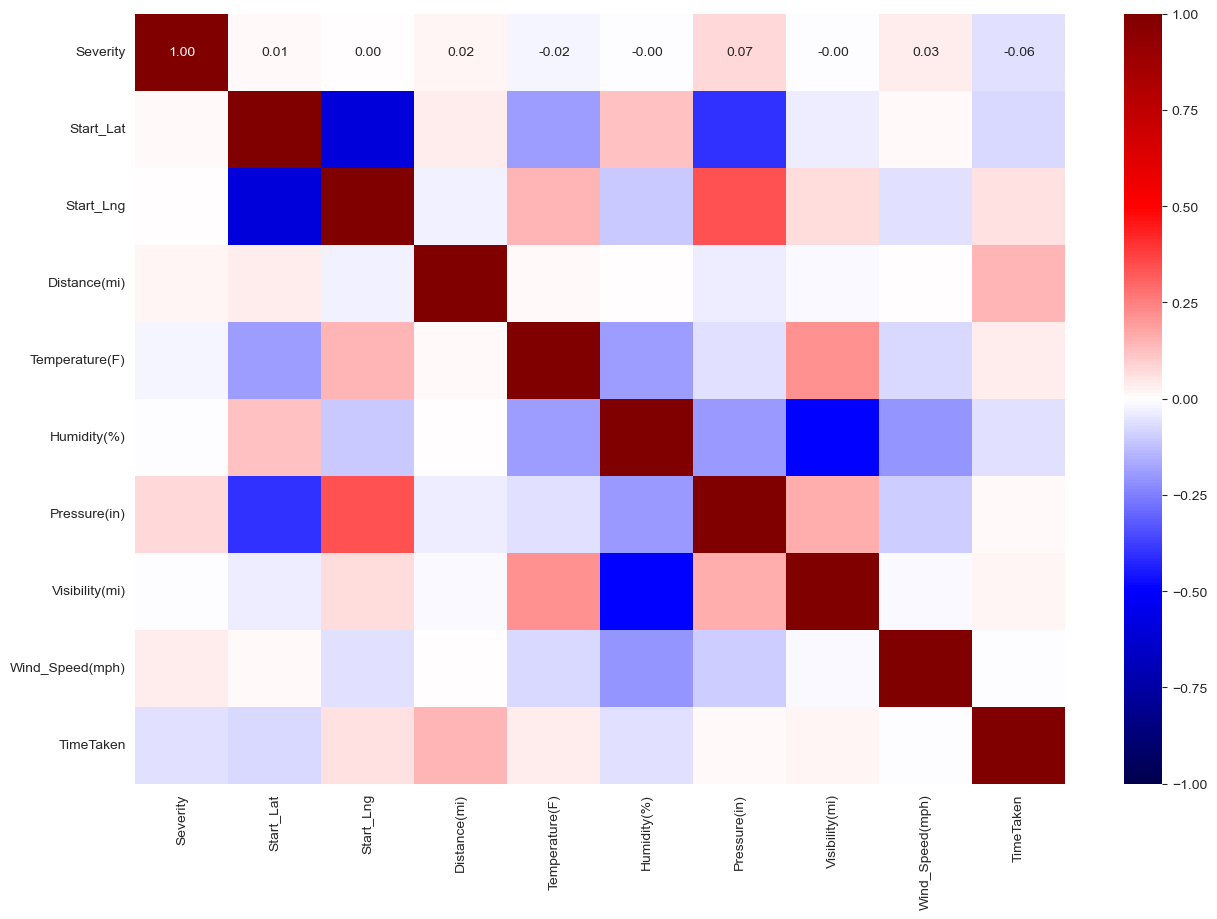

In [41]:
# Assuming df_processed is your DataFrame
corr_matrix = data[['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)','Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)','TimeTaken']].corr()

plt.figure(figsize=(15, 10))
# Use vmin and vmax to set the color scale to represent correlation values between -1 and 1
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="seismic", fmt=".2f")
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

In [42]:
data.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'Street', 'Zipcode', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'TimeTaken'],
      dtype='object')

# Scaling and Target Encoding  

In [43]:
data.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'Street', 'Zipcode', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'TimeTaken'],
      dtype='object')

In [44]:
data = data.drop('Wind_Speed(mph)', axis=1)

In [45]:
scaler = StandardScaler()
data[['Start_Lat', 'Start_Lng', 'Distance(mi)','Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'TimeTaken']] = scaler.fit_transform(data[['Start_Lat', 'Start_Lng', 'Distance(mi)','Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'TimeTaken']])
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,-0.472877,0.205818,-0.361368,Main St,07050-1520,-0.053000,1.345197,-0.208519,...,0,0,0,1,0,1,0,0,0,-0.542339
1,3,2016-11-30 16:25:41,-0.109174,0.256066,-0.361368,Route 17,10974,-0.152607,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.541330
2,3,2016-11-30 15:40:06,-0.129749,0.263616,0.946431,I-287 S,10901,-0.152607,1.345197,-0.094983,...,0,0,0,0,0,0,0,0,0,-0.202782
3,3,2016-11-30 15:26:18,-0.234462,0.593365,0.240635,Hutchinson River Pkwy S,10605,-0.210275,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.201521
4,3,2016-11-30 16:14:11,0.141869,0.682244,-0.361368,I-84 E,10509,-0.210275,1.149605,-0.009831,...,0,0,0,0,0,0,0,0,0,-0.541330


In [46]:
Te = TargetEncoder(target_type='continuous')
data[['Zipcode','Street','Wind_Direction','Weather_Condition']] = Te.fit_transform(data[['Zipcode','Street','Wind_Direction','Weather_Condition']], data.Severity)

In [47]:
data[['Zipcode','Street','Wind_Direction','Weather_Condition']] = scaler.fit_transform(data[['Street','Zipcode','Wind_Direction','Weather_Condition']])
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,-0.472877,0.205818,-0.361368,-0.002357,0.581094,-0.053000,1.345197,-0.208519,...,0,0,0,1,0,1,0,0,0,-0.542339
1,3,2016-11-30 16:25:41,-0.109174,0.256066,-0.361368,0.547821,2.793280,-0.152607,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.541330
2,3,2016-11-30 15:40:06,-0.129749,0.263616,0.946431,1.152862,0.899015,-0.152607,1.345197,-0.094983,...,0,0,0,0,0,0,0,0,0,-0.202782
3,3,2016-11-30 15:26:18,-0.234462,0.593365,0.240635,-0.042970,-0.217501,-0.210275,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.201521
4,3,2016-11-30 16:14:11,0.141869,0.682244,-0.361368,0.632058,1.180043,-0.210275,1.149605,-0.009831,...,0,0,0,0,0,0,0,0,0,-0.541330


In [48]:
data[['Wind_Direction','Weather_Condition']] = Te.fit_transform(data[['Wind_Direction','Weather_Condition']], data.Severity)
data[['Wind_Direction','Weather_Condition']] = scaler.fit_transform(data[['Wind_Direction','Weather_Condition']])
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,-0.472877,0.205818,-0.361368,-0.002357,0.581094,-0.053000,1.345197,-0.208519,...,0,0,0,1,0,1,0,0,0,-0.542339
1,3,2016-11-30 16:25:41,-0.109174,0.256066,-0.361368,0.547821,2.793280,-0.152607,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.541330
2,3,2016-11-30 15:40:06,-0.129749,0.263616,0.946431,1.152862,0.899015,-0.152607,1.345197,-0.094983,...,0,0,0,0,0,0,0,0,0,-0.202782
3,3,2016-11-30 15:26:18,-0.234462,0.593365,0.240635,-0.042970,-0.217501,-0.210275,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.201521
4,3,2016-11-30 16:14:11,0.141869,0.682244,-0.361368,0.632058,1.180043,-0.210275,1.149605,-0.009831,...,0,0,0,0,0,0,0,0,0,-0.541330


In [49]:
le = LabelEncoder()
data[['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']] = data[['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']].apply(le.fit_transform)
data.head()

,Severity,Start_Time,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,TimeTaken
0,2,2016-11-30 16:37:24,-0.472877,0.205818,-0.361368,-0.002357,0.581094,-0.053000,1.345197,-0.208519,...,0,0,0,1,0,1,0,0,0,-0.542339
1,3,2016-11-30 16:25:41,-0.109174,0.256066,-0.361368,0.547821,2.793280,-0.152607,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.541330
2,3,2016-11-30 15:40:06,-0.129749,0.263616,0.946431,1.152862,0.899015,-0.152607,1.345197,-0.094983,...,0,0,0,0,0,0,0,0,0,-0.202782
3,3,2016-11-30 15:26:18,-0.234462,0.593365,0.240635,-0.042970,-0.217501,-0.210275,1.345197,-0.151751,...,0,0,0,0,0,0,0,0,0,-0.201521
4,3,2016-11-30 16:14:11,0.141869,0.682244,-0.361368,0.632058,1.180043,-0.210275,1.149605,-0.009831,...,0,0,0,0,0,0,0,0,0,-0.541330


In [50]:
data = data.drop('Start_Time', axis=1)

In [ ]:
#filename = 'ney york accidents preprocessed.csv'
#data.to_csv(path_or_buf=filename, index=False)

# Model creation and analysis 

# Random Forest 

In [51]:
# Metric printing 
def metric_analysis(ytrue,ypred):
    print(confusion_matrix(ytrue,ypred))
    print("the accuracy is ",accuracy_score(ytrue,ypred))
    #print("the precision is ",precision_score(ytrue,ypred))
    #print("the recall is ",recall_score(ytrue,ypred))
    print(classification_report(ytrue, ypred))
    return accuracy_score(ytrue,ypred)#, precision_score(ytrue,ypred), recall_score(ytrue,ypred)

In [52]:
data = data.drop('TimeTaken', axis=1)

In [54]:
#data = data.drop('TimeTaken',axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(
    data.drop('Severity',axis=1),
    data.Severity,
    test_size=0.2
)

In [55]:
rlf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    n_jobs=-1
)

In [56]:
rlf.fit(xtrain, ytrain)

RandomForestClassifier(n_jobs=-1)

In [57]:
ytrainpred = rlf.predict(xtrain)

In [58]:
print("The training accuracy is ")
metric_analysis(ytrain, ytrainpred)

The training accuracy is 
[[  1172      1      0      0]
 [     0 291011      5     16]
 [     0     10  73318      1]
 [     0    106      0  12870]]
the accuracy is  0.9996327706005126
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1173
           2       1.00      1.00      1.00    291032
           3       1.00      1.00      1.00     73329
           4       1.00      0.99      1.00     12976

    accuracy                           1.00    378510
   macro avg       1.00      1.00      1.00    378510
weighted avg       1.00      1.00      1.00    378510


0.9996327706005126

In [59]:
ypred = rlf.predict(xtest)
print("The test metrics are")
metric_analysis(ytest, ypred)

The test metrics are
[[   33   207    33     0]
 [    2 70087  2633   248]
 [    1  4749 13272    29]
 [    0  2455   144   735]]
the accuracy is  0.8890286173225683
              precision    recall  f1-score   support

           1       0.92      0.12      0.21       273
           2       0.90      0.96      0.93     72970
           3       0.83      0.74      0.78     18051
           4       0.73      0.22      0.34      3334

    accuracy                           0.89     94628
   macro avg       0.84      0.51      0.57     94628
weighted avg       0.88      0.89      0.88     94628


0.8890286173225683

# Feature importance 

The most important features according to random forest are

In [60]:
data.columns[1:][np.argsort(rlf.feature_importances_)[::-1]]

Index(['Distance(mi)', 'Zipcode', 'Street', 'Weather_Condition', 'Start_Lat',
       'Start_Lng', 'Pressure(in)', 'Temperature(F)', 'Wind_Direction',
       'Humidity(%)', 'Visibility(mi)', 'Traffic_Signal', 'Junction',
       'Sunrise_Sunset', 'Crossing', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Stop', 'Amenity', 'Station', 'Give_Way',
       'Railway', 'Traffic_Calming', 'No_Exit', 'Bump', 'Roundabout',
       'Turning_Loop'],
      dtype='object')

# KNN

In [62]:
param_grid = {
    'n_neighbors':[4,5,9,10],
    'weights':['uniform', 'distance']
}
best = GridSearchCV(
    KNeighborsClassifier(n_jobs= -1),
    param_grid=param_grid,
    n_jobs=-1
)

* Getting the best features according to random forest

In [63]:
xtrain = xtrain[['Zipcode', 'Distance(mi)', 'Street', 'Start_Lat','Start_Lng']]
xtest  = xtest[['Zipcode', 'Distance(mi)', 'Street', 'Start_Lat','Start_Lng']]

In [64]:
best.fit(xtrain, ytrain)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'n_neighbors': [4, 5, 9, 10],
                         'weights': ['uniform', 'distance']})

In [65]:
best.best_params_

{'n_neighbors': 10, 'weights': 'distance'}

In [66]:
n_neighbors, weights = best.best_params_.values()

In [68]:
knn = KNeighborsClassifier(
    n_neighbors= n_neighbors,
    weights= weights,
    n_jobs = -1
)

In [69]:
knn.fit(xtrain, ytrain)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [70]:
ypred = knn.predict(xtest)

Test metrics for KNN 

In [71]:
metric_analysis(ytest, ypred)

[[   34   189    44     6]
 [   77 68388  3918   587]
 [   25  4963 12973    90]
 [    7  2420   237   670]]
the accuracy is  0.8672380267996788
              precision    recall  f1-score   support

           1       0.24      0.12      0.16       273
           2       0.90      0.94      0.92     72970
           3       0.76      0.72      0.74     18051
           4       0.50      0.20      0.29      3334

    accuracy                           0.87     94628
   macro avg       0.60      0.50      0.53     94628
weighted avg       0.86      0.87      0.86     94628


0.8672380267996788

# Neural Network 

In [132]:
#data = data.drop('TimeTaken',axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(
    data.drop('Severity',axis=1),
    data.Severity,
    test_size=0.2
)

In [136]:
model = Sequential()
model.add(
    Dense(
        units= 50,
        activation='sigmoid',
        input_shape= (28,)
    )
)
model.add(Dropout(0.2))
model.add(Dense(
    units=25,
    activation='sigmoid',
))
model.add(Dropout(0.1))
model.add(Dense(
    units = 4,
    activation='softmax'
))

In [137]:
opt = Adam(learning_rate = 0.005)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [138]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 50)                1450      
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 104       
                                                                 
Total params: 2829 (11.05 KB)
Trainable params: 2829 (11.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [139]:
model.fit(xtrain,ytrain, epochs=3)

Epoch 1/3


2023-12-04 01:00:10.942782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


11829/11829 [==============================] - 74s 6ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.8236
Epoch 2/3
11829/11829 [==============================] - 70s 6ms/step - loss: 0.3712 - sparse_categorical_accuracy: 0.8307
Epoch 3/3
11829/11829 [==============================] - 70s 6ms/step - loss: 0.3796 - sparse_categorical_accuracy: 0.8285


In [141]:
model.evaluate(xtrain,ytrain)

11829/11829 [==============================] - 42s 3ms/step - loss: 0.4171 - sparse_categorical_accuracy: 0.7996


[0.4171343445777893, 0.7996037006378174]

In [142]:
model.evaluate(xtest,ytest)

2958/2958 [==============================] - 11s 4ms/step - loss: 0.4194 - sparse_categorical_accuracy: 0.7979


[0.41943538188934326, 0.7978610992431641]

In [143]:
trainpred = model.predict(xtrain)

11829/11829 [==============================] - 16s 1ms/step


In [144]:
metric_analysis(ytrain, trainpred.argmax(axis=1))

[[     0   1153      5      0]
 [     0 289745   1524      0]
 [     0  60127  12913      0]
 [     0  12994     49      0]]
the accuracy is  0.7996037092811287
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1158
           2       0.80      0.99      0.88    291269
           3       0.89      0.18      0.30     73040
           4       0.00      0.00      0.00     13043

    accuracy                           0.80    378510
   macro avg       0.42      0.29      0.29    378510
weighted avg       0.78      0.80      0.74    378510


/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

0.7996037092811287

In [145]:
ypred = model.predict(xtest)
ypred

2958/2958 [==============================] - 4s 1ms/step


array([[1.6472804e-08, 5.6715799e-03, 8.9876318e-01, 9.5565185e-02],
       [1.6462161e-08, 5.6693004e-03, 8.9906019e-01, 9.5270574e-02],
       [1.6475852e-08, 5.6719375e-03, 8.9871013e-01, 9.5617890e-02],
       ...,
       [1.6474033e-08, 5.6720036e-03, 8.9872062e-01, 9.5607325e-02],
       [1.6428945e-08, 5.6737689e-03, 8.9954913e-01, 9.4777063e-02],
       [1.6471832e-08, 5.6719375e-03, 8.9871013e-01, 9.5617890e-02]],
      dtype=float32)

In [146]:
metric_analysis(ytest, ypred.argmax(axis=1))

[[    0   286     2     0]
 [    0 72342   391     0]
 [    0 15182  3158     0]
 [    0  3258     9     0]]
the accuracy is  0.7978610981950374
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       288
           2       0.79      0.99      0.88     72733
           3       0.89      0.17      0.29     18340
           4       0.00      0.00      0.00      3267

    accuracy                           0.80     94628
   macro avg       0.42      0.29      0.29     94628
weighted avg       0.78      0.80      0.73     94628


/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

0.7978610981950374

# Naive Bayes 

In [72]:
#data = data.drop('TimeTaken',axis=1)
xtrain, xtest, ytrain, ytest = train_test_split(
    data.drop('Severity',axis=1),
    data.Severity,
    test_size=0.2
)

In [73]:
xtrain = xtrain[['Amenity', 'Bump', 'Crossing','Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station','Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight']]
xtest = xtest[['Amenity', 'Bump', 'Crossing','Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station','Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight','Astronomical_Twilight']]

In [74]:
naive = MultinomialNB()
naive.fit(xtrain, ytrain)

MultinomialNB()

In [75]:
trainpred = naive.predict(xtrain)
metric_analysis(ytrain, trainpred)

[[     0   1121      0      0]
 [     0 291047    138      0]
 [     0  73036     66      0]
 [     0  13095      7      0]]
the accuracy is  0.7691025336186627
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1121
           2       0.77      1.00      0.87    291185
           3       0.31      0.00      0.00     73102
           4       0.00      0.00      0.00     13102

    accuracy                           0.77    378510
   macro avg       0.27      0.25      0.22    378510
weighted avg       0.65      0.77      0.67    378510


/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

0.7691025336186627

# Adaboost

In [76]:
xtrain, xtest, ytrain, ytest = train_test_split(
    data.drop('Severity',axis=1),
    data.Severity,
    test_size=0.3
)

In [77]:
adaboost = AdaBoostClassifier(n_estimators=50)
adaboost.fit(xtrain, ytrain)

AdaBoostClassifier()

In [78]:
trainpred = adaboost.predict(xtrain)
metric_analysis(ytrain, trainpred)

[[    11    874    127      0]
 [    60 241923  11416   1264]
 [    11  25028  38841    202]
 [     1   9426    622   1390]]
the accuracy is  0.8519577531129603
              precision    recall  f1-score   support

           1       0.13      0.01      0.02      1012
           2       0.87      0.95      0.91    254663
           3       0.76      0.61      0.67     64082
           4       0.49      0.12      0.19     11439

    accuracy                           0.85    331196
   macro avg       0.56      0.42      0.45    331196
weighted avg       0.84      0.85      0.84    331196


0.8519577531129603

In [79]:
ypred = adaboost.predict(xtest)
metric_analysis(ytest, ypred)

[[     7    370     55      2]
 [    26 103906   4871    536]
 [     5  10633  16562     98]
 [     1   4036    259    575]]
the accuracy is  0.8528131208521791
              precision    recall  f1-score   support

           1       0.18      0.02      0.03       434
           2       0.87      0.95      0.91    109339
           3       0.76      0.61      0.68     27298
           4       0.47      0.12      0.19      4871

    accuracy                           0.85    141942
   macro avg       0.57      0.42      0.45    141942
weighted avg       0.84      0.85      0.84    141942


0.8528131208521791

# XGboost 

In [80]:
le = LabelEncoder()
le.fit(ytrain.ravel())

LabelEncoder()

In [81]:
ytrain =pd.DataFrame(le.transform(ytrain))
ytest = pd.DataFrame(le.transform(ytest))

In [82]:
xgb = XGBClassifier(n_jobs=-1)

In [83]:
xgb.fit(xtrain, ytrain)
trainpred = xgb.predict(xtrain)

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U

In [84]:
metric_analysis(ytrain, trainpred)

[[   173    724    115      0]
 [     1 244461   9701    500]
 [     1  16443  47480    158]
 [     0   7666    512   3261]]
the accuracy is  0.8918435005253686
              precision    recall  f1-score   support

           0       0.99      0.17      0.29      1012
           1       0.91      0.96      0.93    254663
           2       0.82      0.74      0.78     64082
           3       0.83      0.29      0.42     11439

    accuracy                           0.89    331196
   macro avg       0.89      0.54      0.61    331196
weighted avg       0.89      0.89      0.88    331196


0.8918435005253686

In [85]:
ypred = xgb.predict(xtest)
metric_analysis(ytest, ypred)

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U

[[    37    346     50      1]
 [     2 104307   4653    377]
 [     2   7545  19653     98]
 [     0   3550    244   1077]]
the accuracy is  0.8811627284383763
              precision    recall  f1-score   support

           0       0.90      0.09      0.16       434
           1       0.90      0.95      0.93    109339
           2       0.80      0.72      0.76     27298
           3       0.69      0.22      0.34      4871

    accuracy                           0.88    141942
   macro avg       0.82      0.50      0.54    141942
weighted avg       0.87      0.88      0.87    141942


0.8811627284383763

MiniBatchKMeans Clustering 

Objective: Cluster the data points based on temperature. Then remove the features realted to temperature and only train on the clustered label. (editor note: this does not affect accuracy, but can lead to interesting use case, and certain problem solving) 

In [88]:
minimeans = MiniBatchKMeans(compute_labels=True, n_clusters=150)
minimeans.fit(data[['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)','Wind_Direction', 'Weather_Condition']])

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=150)

In [89]:
minimeans.inertia_

360563.8975784617

In [90]:
data['tempClusters'] = minimeans.labels_
data.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,tempClusters
0,2,-0.472877,0.205818,-0.361368,-0.002357,0.581094,-0.053000,1.345197,-0.208519,-2.404577,...,0,0,0,1,0,1,0,0,0,5
1,3,-0.109174,0.256066,-0.361368,0.547821,2.793280,-0.152607,1.345197,-0.151751,-2.959664,...,0,0,0,0,0,0,0,0,0,3
2,3,-0.129749,0.263616,0.946431,1.152862,0.899015,-0.152607,1.345197,-0.094983,-2.959664,...,0,0,0,0,0,0,0,0,0,3
3,3,-0.234462,0.593365,0.240635,-0.042970,-0.217501,-0.210275,1.345197,-0.151751,-2.589606,...,0,0,0,0,0,0,0,0,0,37
4,3,0.141869,0.682244,-0.361368,0.632058,1.180043,-0.210275,1.149605,-0.009831,-2.219548,...,0,0,0,0,0,0,0,0,0,5


In [91]:
data = data.drop(columns=['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)','Wind_Direction', 'Weather_Condition'], axis=1)

In [92]:
te = TargetEncoder(target_type='continuous')
data[['tempClusters']] = te.fit_transform(data[['tempClusters']], data.Severity)
data.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Amenity,Bump,Crossing,Give_Way,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,tempClusters
0,2,-0.472877,0.205818,-0.361368,-0.002357,0.581094,0,0,0,0,...,0,0,0,1,0,1,0,0,0,2.269949
1,3,-0.109174,0.256066,-0.361368,0.547821,2.793280,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.421733
2,3,-0.129749,0.263616,0.946431,1.152862,0.899015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.419530
3,3,-0.234462,0.593365,0.240635,-0.042970,-0.217501,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.255394
4,3,0.141869,0.682244,-0.361368,0.632058,1.180043,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.269270


In [93]:
scaler = StandardScaler()
data[['tempClusters']] = scaler.fit_transform(data[['tempClusters']])
data.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Amenity,Bump,Crossing,Give_Way,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,tempClusters
0,2,-0.472877,0.205818,-0.361368,-0.002357,0.581094,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0.112333
1,3,-0.109174,0.256066,-0.361368,0.547821,2.793280,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.672663
2,3,-0.129749,0.263616,0.946431,1.152862,0.899015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.650013
3,3,-0.234462,0.593365,0.240635,-0.042970,-0.217501,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.037287
4,3,0.141869,0.682244,-0.361368,0.632058,1.180043,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.105354


THIS LINK BELOW SAVES THE NEW CLUSTERED DATASET AS A FILE CALLED NEW YORK ACCIDENT MINI MEANS CLUSTERED. you can use this dataset and re run on already ran algorithms to test a difference in output if you would like 

In [94]:
'''
link = './accident dataset/new york accident minimeans clustered.csv'
data.to_csv(path_or_buf=link, index=False)'''

"\nlink = './accident dataset/new york accident minimeans clustered.csv'\ndata.to_csv(path_or_buf=link, index=False)"

To test the difference in accuracy please re run all the models with the new dataset to see changes in accuracy. If youd like to see the results please launch individual codes, (for example `xgboost.ipynb`) and the bottom segment performs the code on the clustered dataset and notes the accuracy. 

# K MEANS CLUSTERED RANDOM FOREST 

In [97]:
data.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,Zipcode,Amenity,Bump,Crossing,Give_Way,...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,tempClusters
0,2,-0.472877,0.205818,-0.361368,-0.002357,0.581094,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0.112333
1,3,-0.109174,0.256066,-0.361368,0.547821,2.793280,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.672663
2,3,-0.129749,0.263616,0.946431,1.152862,0.899015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.650013
3,3,-0.234462,0.593365,0.240635,-0.042970,-0.217501,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.037287
4,3,0.141869,0.682244,-0.361368,0.632058,1.180043,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.105354


In [98]:
xtrain, xtest, ytrain, ytest = train_test_split(
    data.drop('Severity',axis=1),
    data.Severity,
    test_size=0.2
)

In [99]:
rlf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    n_jobs=-1
)
rlf.fit(xtrain, ytrain)

RandomForestClassifier(n_jobs=-1)

In [100]:
trainpred = rlf.predict(xtrain)
metric_analysis(ytrain, trainpred)

[[  1137      0      1      0]
 [     0 291044    109     14]
 [     0     85  73067      2]
 [     0    104      2  12945]]
the accuracy is  0.9991625056141186
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1138
           2       1.00      1.00      1.00    291167
           3       1.00      1.00      1.00     73154
           4       1.00      0.99      1.00     13051

    accuracy                           1.00    378510
   macro avg       1.00      1.00      1.00    378510
weighted avg       1.00      1.00      1.00    378510


0.9991625056141186

In [101]:
ypred = rlf.predict(xtest)
metric_analysis(ypred, ytest)

[[   43    17    10     0]
 [  237 69727  4801  2324]
 [   27  2784 13348   162]
 [    1   307    67   773]]
the accuracy is  0.8865346409096674
              precision    recall  f1-score   support

           1       0.14      0.61      0.23        70
           2       0.96      0.90      0.93     77089
           3       0.73      0.82      0.77     16321
           4       0.24      0.67      0.35      1148

    accuracy                           0.89     94628
   macro avg       0.52      0.75      0.57     94628
weighted avg       0.91      0.89      0.90     94628


0.8865346409096674

Very similar accuracy to the random forest model without clustering 

# KNN on data with temp clusters

In [102]:
xtrain = xtrain[['Zipcode', 'Distance(mi)', 'Street', 'Start_Lat','Start_Lng','tempClusters']]
xtest = xtest[['Zipcode', 'Distance(mi)', 'Street', 'Start_Lat','Start_Lng','tempClusters']]

In [103]:
knn = KNeighborsClassifier(
    n_neighbors= n_neighbors,
    weights=weights,
    n_jobs=-1,
)
knn.fit(xtrain, ytrain)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [104]:
ypred = knn.predict(xtest)
metric_analysis(ytest, ypred)

[[   24   251    33     0]
 [   21 68075  4416   323]
 [    6  5938 12227    55]
 [    3  2333   345   578]]
the accuracy is  0.8549689309718054
              precision    recall  f1-score   support

           1       0.44      0.08      0.13       308
           2       0.89      0.93      0.91     72835
           3       0.72      0.67      0.69     18226
           4       0.60      0.18      0.27      3259

    accuracy                           0.85     94628
   macro avg       0.66      0.47      0.50     94628
weighted avg       0.84      0.85      0.84     94628


0.8549689309718054

Once again, no real change from the metrics obtained from non clustered KNN 

# Adaboost on clustered Data

In [105]:
xtrain, xtest, ytrain, ytest = train_test_split(
    data.drop('Severity',axis=1),
    data.Severity,
    test_size=0.2
)
adaboost = AdaBoostClassifier(n_estimators=50)
adaboost.fit(xtrain, ytrain)

AdaBoostClassifier()

In [107]:
trainpred = adaboost.predict(xtrain)
metric_analysis(ytrain, trainpred)

[[     1   1053    130      0]
 [     5 277249  12984   1140]
 [     0  28410  44327    183]
 [     0  11031    765   1232]]
the accuracy is  0.8528414044543077
              precision    recall  f1-score   support

           1       0.17      0.00      0.00      1184
           2       0.87      0.95      0.91    291378
           3       0.76      0.61      0.68     72920
           4       0.48      0.09      0.16     13028

    accuracy                           0.85    378510
   macro avg       0.57      0.41      0.44    378510
weighted avg       0.84      0.85      0.84    378510


0.8528414044543077

In [108]:
ypred = adaboost.predict(xtest)
metric_analysis(ytest, ypred)

[[    1   231    30     0]
 [    0 69104  3233   287]
 [    0  7165 11254    41]
 [    0  2808   185   289]]
the accuracy is  0.8522636006256077
              precision    recall  f1-score   support

           1       1.00      0.00      0.01       262
           2       0.87      0.95      0.91     72624
           3       0.77      0.61      0.68     18460
           4       0.47      0.09      0.15      3282

    accuracy                           0.85     94628
   macro avg       0.78      0.41      0.44     94628
weighted avg       0.84      0.85      0.84     94628


0.8522636006256077

# XGBoost on Clustered Dataset

In [109]:
# le is the label encoder
le.fit(ytrain.ravel())

LabelEncoder()

In [110]:
ytrain =pd.DataFrame(le.transform(ytrain))
ytest = pd.DataFrame(le.transform(ytest))

In [111]:
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(xtrain, ytrain)
trainpred = xgb.predict(xtrain)
metric_analysis(ytrain, trainpred)

/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U

[[   138    901    145      0]
 [     7 279027  11731    613]
 [     1  18898  53817    204]
 [     0   8856    575   3597]]
the accuracy is  0.8892208924466989
              precision    recall  f1-score   support

           0       0.95      0.12      0.21      1184
           1       0.91      0.96      0.93    291378
           2       0.81      0.74      0.77     72920
           3       0.81      0.28      0.41     13028

    accuracy                           0.89    378510
   macro avg       0.87      0.52      0.58    378510
weighted avg       0.89      0.89      0.88    378510


0.8892208924466989

In [112]:
ypred = xgb.predict(xtest)
metric_analysis(ytest, ypred)

[[   12   216    34     0]
 [    7 69341  3017   259]
 [    0  5005 13403    52]
 [    0  2413   162   707]]
the accuracy is  0.882011666737118
              precision    recall  f1-score   support

           0       0.63      0.05      0.09       262
           1       0.90      0.95      0.93     72624
           2       0.81      0.73      0.76     18460
           3       0.69      0.22      0.33      3282

    accuracy                           0.88     94628
   macro avg       0.76      0.49      0.53     94628
weighted avg       0.87      0.88      0.87     94628


/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/Users/manedge/miniconda/envs/EnvironmentTest/lib/python3.11/site-packages/xgboost/data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. U

0.882011666737118

ANALYSIS: for most of the models the accuracy is barely differing by 1% after clustering. This is not a significant difference to even consider. This might mean that the temperature values are not as important or that the clusters are working way too well. More likely that the cluster analysis is a very good representation of the temperature data as random forest values temperature data pretty high ( it is the sixth or seventh most important feature). This can be used for data augmentation later on 